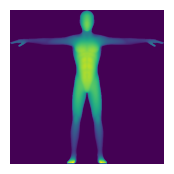

<Figure size 640x480 with 0 Axes>

In [1]:
from text3d2video.camera_placement import front_facing_extrinsics
from pytorch3d.io import load_objs_as_meshes

from pytorch3d.renderer import FoVOrthographicCameras
from text3d2video.ipython_utils import display_ims
from text3d2video.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map

mesh = "mixamo-human"

meshes = load_objs_as_meshes([f"data/meshes/{mesh}.obj"], device="cuda")
meshes = normalize_meshes(meshes)

dist = 1
s = 2

R, T = front_facing_extrinsics(zs=dist)
cams = FoVOrthographicCameras(device="cuda", R=R, T=T, scale_xyz=[(s, s, s)])
meshes = meshes.extend(len(cams))

depths = render_depth_map(meshes, cams)

display_ims(depths)

In [ ]:
from diffusers import ControlNetModel
import torch
from diffusers import DPMSolverMultistepScheduler

from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe: ControlNetPipeline = ControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 14.75it/s]


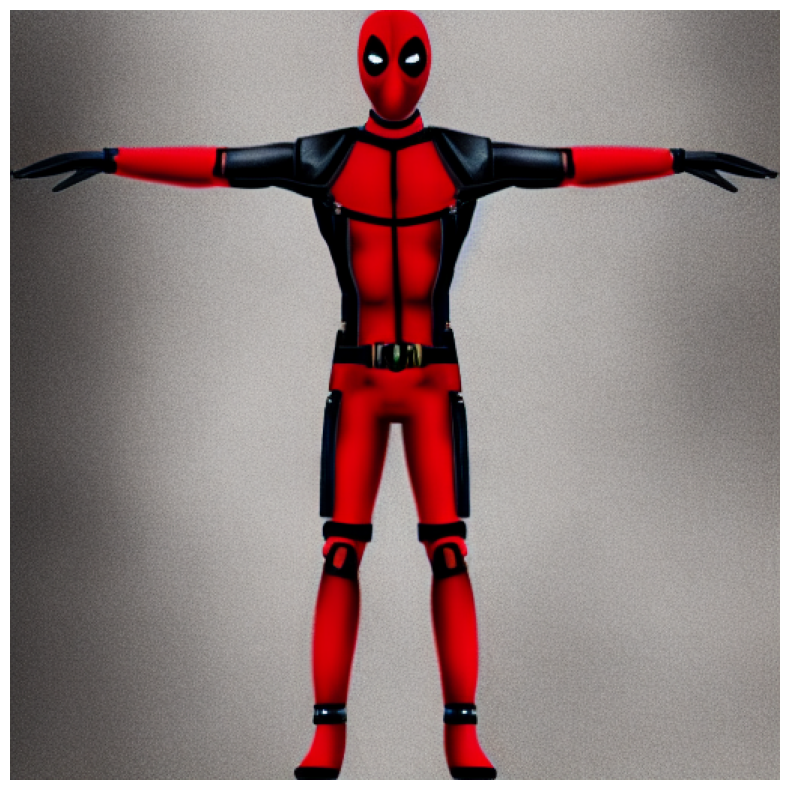

<Figure size 640x480 with 0 Axes>

In [12]:
prompt = "Deadpool, simple white background"

gen = torch.Generator(device=device)
gen.manual_seed(0)

ims = pipe([prompt] * len(depths), depths, generator=gen, num_inference_steps=10)
display_ims(ims, scale=10)